In [1]:
import sys

main_path = '/home/david/data/searchingfornues/v08_00_00_25/cc0pinp/1013/'
sys.path.append(main_path)

In [2]:
SHRCALIBFACTOR = 1.00

In [3]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)


In [4]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open(main_path+"prodgenie_bnb_nu_uboone_overlay_mcc9.1_run3_G_reco2.root")[fold][tree]
#nc = uproot.open(main_path+"prodgenie_nc_pi0_uboone_overlay-v08_00_00_16_run1_reco2.root")[fold][tree]
nue = uproot.open(main_path+"prodgenie_bnb_intrinsic_nue_uboone_overlay_mcc9.1_run3_G_reco2.root")[fold][tree]
data = uproot.open(main_path+"data_bnb_optfilter_G1_1e19_mcc9.1_reco2.root")[fold][tree]
ext = uproot.open(main_path+"data_extbnb_mcc9.1_v08_00_00_16_18_run3_G_reco2.root")[fold][tree]
dirt = uproot.open(main_path+"prodgenie_bnb_dirt_overlay_run3_mcc9.1_v08_00_00_18_G_reco2.root")[fold][tree]
lee = uproot.open(main_path+"prodgenie_bnb_intrinsic_nue_uboone_overlay_mcc9.1_run3_G_reco2.root")[fold][tree]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", "shr_theta_v", "trk_score_v", # modified from shr_score_v
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", 
    "shr_energy_tot", "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", "shr_dedx_y_v",
    "crtveto","crthitpe","_closestNuCosmicDist","slclustfrac",
    "reco_nu_vtx_x","reco_nu_vtx_y","reco_nu_vtx_z",
    "NeutrinoEnergy2",
    "run","sub","evt",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "trk_chipr_best", "trk_chipr_worst", "trk_pida", "trk_chimu", "CosmicIP", "trk_bragg_p", "trk_bragg_mu",
    "trk_bragg_mip", "shr_chipr", "shr_bragg_p", "shr_bragg_mu", "shr_chimu",
    "shr_pca_2", "shr_pca_0", "shr_pca_1", "npi0", "gamma1_edep", "gamma2_edep", "topological_score",
    "bdt_nuNCpi0","bdt_numuCCpi0","bdt_numuCC","bdt_ext","bdt_cosmic","bdt_global",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction"#
]

nue = nue.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
mc = mc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
#nc = nc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
lee = lee.pandas.df(variables + ["weightSpline", "leeweight"], flatten=False)

ext["shr_dedx_Y"] = ext["shr_dedx_Y"] * SHRCALIBFACTOR
data["shr_dedx_Y"] = data["shr_dedx_Y"] * SHRCALIBFACTOR
ext["shr_dedx_Y_cali"] = ext["shr_dedx_Y_cali"] * SHRCALIBFACTOR
data["shr_dedx_Y_cali"] = data["shr_dedx_Y_cali"] * SHRCALIBFACTOR
ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"] * SHRCALIBFACTOR
data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"] * SHRCALIBFACTOR
ext["shr_dedx_y_v"] = ext["shr_dedx_y_v"] * SHRCALIBFACTOR
data["shr_dedx_y_v"] = data["shr_dedx_y_v"] * SHRCALIBFACTOR
ext["shr_energy_tot"] = ext["shr_energy_tot"] * SHRCALIBFACTOR
data["shr_energy_tot"] = data["shr_energy_tot"] * SHRCALIBFACTOR
ext["shr_energy_tot_cali"] = ext["shr_energy_tot_cali"] * SHRCALIBFACTOR
data["shr_energy_tot_cali"] = data["shr_energy_tot_cali"] * SHRCALIBFACTOR

lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
#nc["is_signal"] = nc["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

#train_nc, nc = train_test_split(nc, test_size=0.5, random_state=1990)
train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
train_lee, lee = train_test_split(lee, test_size=0.5, random_state=1990)
train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [ ]:
features = nue_booster.variables.copy()
features.remove("is_signal")
features.remove("nu_e")
features.remove("train_weight")
# features.remove('shr_energy_tot_cali')
# features.remove('trk_energy_tot')

for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    with open(main_path+'pickles/booster_%s.pickle' % label, 'rb') as booster_file:
        booster = pickle.load(booster_file)
        mc[label+"_score"] = booster.predict(
            xgb.DMatrix(mc[features]),
            ntree_limit=booster.best_iteration + 1)
        nue[label+"_score"] = booster.predict(
            xgb.DMatrix(nue[features]),
            ntree_limit=booster.best_iteration + 1)
        ext[label+"_score"] = booster.predict(
            xgb.DMatrix(ext[features]),
            ntree_limit=booster.best_iteration + 1)
        data[label+"_score"] = booster.predict(
            xgb.DMatrix(data[features]),
            ntree_limit=booster.best_iteration + 1)
        dirt[label+"_score"] = booster.predict(
            xgb.DMatrix(dirt[features]),
            ntree_limit=booster.best_iteration + 1)
        lee[label+"_score"] = booster.predict(
            xgb.DMatrix(lee[features]),
            ntree_limit=booster.best_iteration + 1)
        #nc[label+"_score"] = booster.predict(
        #    xgb.DMatrix(nc[features]),
        #    ntree_limit=booster.best_iteration + 1)
features = ["%s_score" % l for l in nue_booster.labels]


In [ ]:
with open(main_path+'pickles/booster.pickle', 'rb') as booster_file:
    booster = pickle.load(booster_file)
    
    mc["global_score"] = booster.predict(
        xgb.DMatrix(mc[features]),
        ntree_limit=booster.best_iteration + 1)
    nue["global_score"] = booster.predict(
        xgb.DMatrix(nue[features]),
        ntree_limit=booster.best_iteration + 1)
    ext["global_score"] = booster.predict(
        xgb.DMatrix(ext[features]),
        ntree_limit=booster.best_iteration + 1)
    data["global_score"] = booster.predict(
        xgb.DMatrix(data[features]),
        ntree_limit=booster.best_iteration + 1)
    dirt["global_score"] = booster.predict(
        xgb.DMatrix(dirt[features]),
        ntree_limit=booster.best_iteration + 1)
    lee["global_score"] = booster.predict(
        xgb.DMatrix(lee[features]),
        ntree_limit=booster.best_iteration + 1)
    #nc["global_score"] = booster.predict(
    #    xgb.DMatrix(nc[features]),
    #    ntree_limit=booster.best_iteration + 1)

In [6]:
lee["reco_e"] = (lee["shr_energy_tot_cali"] + 0.030) / 0.79 + lee["trk_energy_tot"]
data["reco_e"] = (data["shr_energy_tot_cali"] + 0.030) / 0.79 + data["trk_energy_tot"]
nue["reco_e"] = (nue["shr_energy_tot_cali"] + 0.030) / 0.79 + nue["trk_energy_tot"]
mc["reco_e"] = (mc["shr_energy_tot_cali"] + 0.030) / 0.79 + mc["trk_energy_tot"]
dirt["reco_e"] = (dirt["shr_energy_tot_cali"] + 0.030) / 0.79 + dirt["trk_energy_tot"]
ext["reco_e"] = (ext["shr_energy_tot_cali"] + 0.030) / 0.79 + ext["trk_energy_tot"]
#nc["reco_e"] = (nc["shr_energy_tot_cali"] + 0.030) / 0.79 + nc["trk_energy_tot"]

samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    #"nc": nc,
    "lee": lee
}

scaling = 1#132.0/4.5

SPLIT = 2.

#''' 1013
weights = {
    "mc": 0.0107 * SPLIT,
    "nue": 0.00008 * SPLIT * scaling,
    "ext": 0.0718 * SPLIT * scaling,
    "dirt": 0.0342 * scaling,
    "lee": 0.00008 * SPLIT * scaling,
    #"nc": 0.021023 * 2 * scaling,
}
#'''



my_plotter = plotter.Plotter(samples, weights, pot=0.9e19)

In [9]:
# giuseppe's box cuts
QUERY = "selected == 1"
QUERY += " and (crtveto!=1 or crthitpe < 100.) and (_closestNuCosmicDist > 20.)"
QUERY += " and (reco_nu_vtx_x>20 & reco_nu_vtx_x<230) "
QUERY += " and (reco_nu_vtx_y>-95 & reco_nu_vtx_y<95)"
QUERY += " and n_showers_contained==1"
QUERY += " and shr_energy_tot_cali>0.08"
QUERY += " and hits_y>50"
QUERY += " and hits_ratio>0.65"
QUERY += " and CosmicIP>30"
QUERY += " and shr_distance<2.5"
QUERY += " and trk_distance<2.5"
QUERY += " and tksh_distance<2"
QUERY += " and tksh_angle>-0.9"
QUERY += " and (shr_tkfit_dedx_Y>0.5 & shr_tkfit_dedx_Y<3.5)"
QUERY += " and shr_score<0.125"
QUERY += " and trk_score>0.85"
QUERY += " and slclustfrac>0.6"
#QUERY += " and reco_e_rqe>0.8"

In [16]:
# nue pre-selection w/ CRT
QUERY = 'selceted == 1'
QUERY += ' and (crtveto!=1 or crthitpe < 100.) and (_closestNuCosmicDist > 20.)'

Profile likelihood: 0.26 sigma @ 1.32e21 POT
s/sqrt(b): 0.13 sigma @ 1.32e21 POT


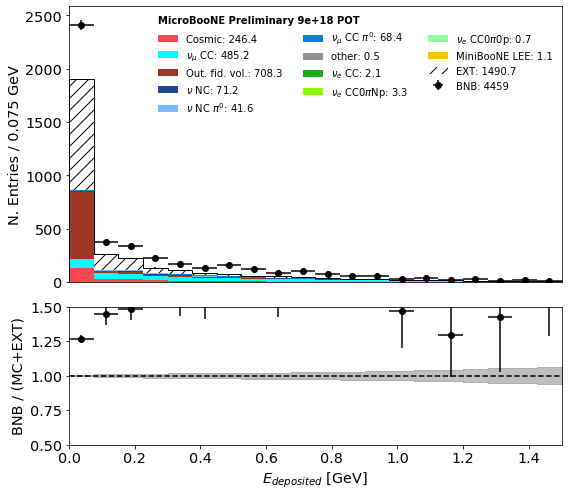

In [17]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

fig, ax1, ax2 = my_plotter.plot_variable(
    "reco_e",
    query=QUERY,
    kind="event_category",
    #kind="interaction",
    #kind="sample",
    draw_sys=False,
    title=r"$E_{deposited}$ [GeV]",
    #bins=miniboone_bins,
    bins=20,
    range=(0.,1.5),
)

print("Profile likelihood: %.2f sigma @ 1.32e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.32e21 POT" % my_plotter.significance)

# ax1.set_ylim(0,450)
# ax1.set_yscale("log")
# ax1.set_ylim(0,1)
ax2.set_ylim(0.5,1.5)
fig.savefig(main_path+"plots/spectrum.pdf")

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

x_range = (0.1,0.8)
n_bins = 7

n_tot = np.empty([50, n_bins])
n_cv_tot = np.empty(n_bins)
n_tot.fill(0)
n_cv_tot.fill(0)
score_cut = 0.997

my_cmap = cm.get_cmap('viridis')

for t in samples:
    if t in ["ext", "data", "lee"]:
        continue
    tree = samples[t]
    
    extra_query = ""
    if t == "mc":
        extra_query = "& ~(nu_pdg == 12 & ccnc == 0) & ~(npi0 != 0 & ccnc == 1)"
        
    queried_tree = tree.query("selected==1 & global_score > %g %s & interaction == 1" % (score_cut, extra_query))
    variable = queried_tree["reco_e"]
    genie_weights = queried_tree["weightsGenie"]
    spline_fix = queried_tree["weightSpline"]*weights[t]

    s = genie_weights
    df = pd.DataFrame(s.values.tolist())


    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=n_bins,
        weights=spline_fix)
    
    n_cv_tot += n_cv

    if not df.empty:
        for i in range(50):
            weight = df[i].values
            weight[np.isnan(weight)] = 1
            weight[weight > 100] = 1

            n, bins = np.histogram(
                variable, weights=weight*spline_fix, range=x_range, bins=n_bins)

            n_tot[i] += n

        
bincenters = 0.5 * (bins[1:] + bins[:-1])

left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([n_cv_tot,n_cv_tot]).T.flatten()
plt.plot(X,Y,color='r',linewidth=2,label='Central value')

    
cov = np.empty([len(n_cv), len(n_cv)])
cov.fill(0)

my_norm = Normalize(vmin=min((sum(n) for n in n_tot)), vmax=max((sum(n) for n in n_tot)))

for n in n_tot:
    left,right = bins[:-1],bins[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([n,n]).T.flatten()
    plt.plot(X,Y,color=my_cmap(my_norm(sum(n))),zorder=-32)
    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

cov /= 50
            
frac_cov = np.empty([len(n_cv), len(n_cv)])
corr = np.empty([len(n_cv), len(n_cv)])

for i in range(len(n_cv)):
    for j in range(len(n_cv)):
        frac_cov[i][j] = cov[i][j] / (n_cv_tot[i] * n_cv_tot[j])
        corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])

        
plt.errorbar(
    bincenters, 
    n_cv_tot,
    yerr=np.sqrt(np.diag(cov)), 
    fmt='none', 
    ecolor='r',
    linewidth=2,
    label='GENIE sys. uncertainties')

print(np.sqrt(np.diag(cov))/n_cv_tot)
plt.xlim(x_range[0], x_range[1])
plt.xlabel(r"$E_{deposited}$ [GeV]")
plt.legend()
plt.ylim(ymin=0)
plt.tight_layout()
plt.savefig("plots/spec.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')
ax.set_title("Fractional covariance matrix")
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/frac.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Correlation matrix")
pos = ax.imshow(corr, origin='lower', cmap='inferno')
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/corr.pdf", transparent=True)

In [ ]:
my_plotter.plot_2d(
    "global_score",
    "ncpi0_score",
    query="selected==1",
    bins_x=50,
    bins_y=50,
    range_x=(0., 1),
    range_y=(0., 1))